# Flame 1 and 2


## Read (unzip) packages from Google drive and add them to the correct directory in colab

In [ ]:
# !unzip -o "/content/drive/MyDrive/Colab Notebooks/lib/cantera_env.zip" -d "/usr/local/lib/python3.7/site-packages/" &> /dev/null

import sys

!wget https://github.com/luukalt/data_analysis/raw/main/cantera_env.zip &> /dev/null

!unzip -o "/content/cantera_env.zip" -d "/usr/local/lib/python3.7/site-packages/" &> /dev/null

colab_package_dir = "/usr/local/lib/python3.7/site-packages/"

sys.path.append(colab_package_dir)

# **Main**



## Import packages

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np
import imutils
import os

## Velocity fluctuations

This part focuses on flame 1 and flame 2 of paper 1.

Flame | $D$ [mm] | $Re_{D}$ [-] | $\phi$ [-] | $H_2\%$ | data directory | comment Filippo Davis
--- | --- | --- | --- | --- | --- | --- |
**flame 1** | 25.7 | 16139 | 0.6 | 100 | U:\High hydrogen\ffaldella\data\Filippo_25mm_ID_Jet_flame_2\Cam_Date=190923_Time=164708 | Re 16 000, dt 26 mus, t lab 22, Qair 262, Qh2 66, h2 100%, phi 0_6
**flame 2** | 25.7 | 12005 | 0.6 | 100 | U:\High hydrogen\ffaldella\data\Filippo_25mm_ID_Jet_flame\Cam_Date=190920_Time=173417 | dt 34, phi 0.6, h2 100%, Qair 195.96, QH2 49.384 , vbulk 8.94, Re 12005, Tlab 21.5 
**flame X** | 25.7 | 11949 | 0.6 | 100 | U:\High hydrogen\ffaldella\data\Filippo_25mm_ID_Jet_flame_3\Cam_Date=190924_Time=105245 | dt 34, phi 0.6, h2 100%, Qair 195.04, QH2 49.15 , vbulk 8.89, Re 11949, Tlab 22


The goal of this notebook is to obtain the statistics regarding the flame front.
Filippo already reported the velocity fluctuations.


**Flame 1**
![flame1](https://drive.google.com/uc?export=view&id=1LFQWAUrUWj1g1X7wC3xU8f-5cj1thkaO)

**Flame 2**
![flame2](https://drive.google.com/uc?export=view&id=1LwVXuZKcrHHVWP7v6HetsXHKEYy7c3uu)


From left to right:  Normalized mean velocity field $\overline{u}/U_{b}$, Normalized Reynolds normal stress in the axial $\overline{u'u'}/U_{b}^2$ and radial direction $\overline{v'v'}/U_{b}^2$, respectively. The dashed line indicates the average flame front location and is used to determine the flame cone angle.




## Flame front detection algoritm [unconfined]




In [ ]:
##% Algoritme to detect the flame front of confinded and unconfined flames from raw PIV images

#%% UNCONFINED
def get_flame_contour_unconfined(image, color): 
    
    basepath = "/content/drive/MyDrive/Colab Notebooks/flame_front_analysis_images/Cam_Date=190923_Time=164708_Frame0/"

    #%% Load image
    img_raw = cv2.imread(basepath + image)
    # imS = cv2.resize(img_raw, (512, 512)) 

    # Display original image
    cv2_imshow(img_raw)

    # #%% Convert image to graycsale
    src = img_raw
    conversion_code = cv2.COLOR_BGR2GRAY
    img_gray = cv2.cvtColor(src, conversion_code)

    #%% Brighten image by blending gray image and blurred image (alpha and beta are the blending weights of the images)
    src1 = imS # First input image array
    alpha = 1000 # Weight of the first array elements
    src2 = imS # Second input image array
    beta = 0 # Weight of the first array elements
    gamma = 0 # Scalar added to each sum
    img_bright1 = cv2.addWeighted(src1, alpha, src2, beta, gamma)
    cv2_imshow(img_bright1)
    
    #%% Blur the image for better edge detection
    src = img_bright1  # Input image array
    ksize = (0,0) # Gaussian Kernel Size. [height width]. height and width should be odd and can have different values. If ksize is set to [0 0], then ksize is computed from sigma values.
    sigmaX = 3 #3 # Kernel standard deviation along X-axis (horizontal direction).
    img_blur = cv2.GaussianBlur(src, ksize, sigmaX)
    cv2_imshow(img_blur)
    
    #%% Brighten image by blending gray image and blurred image (alpha and beta are the blending weights of the images)
    src1 = img_bright1 # First input image array
    alpha = -1 # Weight of the first array elements
    src2 = img_blur# Second input image array
    beta = 5 # Weight of the first array elements
    gamma = 0 # Scalar added to each sum
    img_bright = cv2.addWeighted(src1, alpha, src2, beta, gamma)
    cv2_imshow(img_bright)
    
    #%% Blur the image for better edge detection 2
    src = img_bright  # Input image array
    ksize = (0,0) # Gaussian Kernel Size. [height width]. height and width should be odd and can have different values. If ksize is set to [0 0], then ksize is computed from sigma values.
    sigmaX = 5 #5 # Kernel standard deviation along X-axis (horizontal direction).
    img_blur2 = cv2.GaussianBlur(src, ksize, sigmaX)
    cv2_imshow(img_blur2)
    
    #%% Create binary image
    src = img_blur2 # Input image array (must be in Grayscale)
    thresholdValue = 120 # Value of Threshold below and above which pixel values will change accordingly. 
    maxVal = 255 # Maximum value that can be assigned to a pixel. 
    threshold_type = cv2.THRESH_BINARY # The type of thresholding to be applied. 
    ret, img_binary = cv2.threshold(src, thresholdValue, maxVal, threshold_type)
    cv2_imshow(img_binary)
    
    #%% Find and draw flame contour
    # Find the contours
    src = img_binary # Input image array
    contour_retrieval = cv2.RETR_TREE # Contour retrieval mode
    contours_approx = cv2.CHAIN_APPROX_NONE
    contours = cv2.findContours(src, contour_retrieval, contours_approx)
    cnts = imutils.grab_contours(contours)
    
    # Find the largest contour
    largest_contour = max(cnts, key=cv2.contourArea)

    # Compute point where flame anchors at burner rim on right and left hand side
    ## image axis start in top left corner and are positive in right and downward direction 
    contour_all_y_values = np.hstack(largest_contour[:,:,1])
    y_max = np.where(contour_all_y_values == max(contour_all_y_values))[0]
    
    contour_x_values_at_y_max = np.hstack(largest_contour[y_max,:,0])
    x_right = np.where(contour_x_values_at_y_max == max(contour_x_values_at_y_max))[0]
    x_left = np.where(contour_x_values_at_y_max == min(contour_x_values_at_y_max))[0]
    
    right_point_index = y_max[x_right[0]] 
    left_point_index = y_max[x_left[0]] 
    
    diff = len(largest_contour) - right_point_index
    
    right_indices = np.linspace(right_point_index, (len(largest_contour) - 1), diff)
    left_indices = np.linspace(0, left_point_index, left_point_index + 1)
    total_indices = np.concatenate((right_indices, left_indices)).astype('int64')
    contour = largest_contour[total_indices]
    
    #%% Draw the largest contour
    shape = img_gray.shape
    dtype = np.uint8 # data type
    img_empty = np.zeros(shape, dtype) # Destination image
    img_empty = cv2.cvtColor(img_empty, cv2.COLOR_GRAY2BGR)
    contourIdx = -1 # Parameter indicating a contour to draw. If it is negative, all the contours are drawn.
    thickness = -1	# Thickness of lines the contours are drawn with. If it is negative, the contour interiors are drawn.
    img_mask = cv2.drawContours(img_empty, largest_contour, contourIdx, color, thickness)
    # cv2_imshow(img_mask)
    
    #%% Draw the flame contour
    # The contour is drawn counterclockwise
    contourIdx = -1 # Parameter indicating a contour to draw. If it is negative, all the contours are drawn.
    thickness = 2	# Thickness of lines the contours are drawn with. If it is negative, the contour interiors are drawn.
    image = cv2.drawContours(img_raw, contour, contourIdx, color, thickness)
    cv2_imshow(image)            
    
    closed_contour = False
    contour_length = cv2.arcLength(contour, closed_contour)
    
    return [contour, contour_length]

## Process raw PIV images to obtain flame fromt

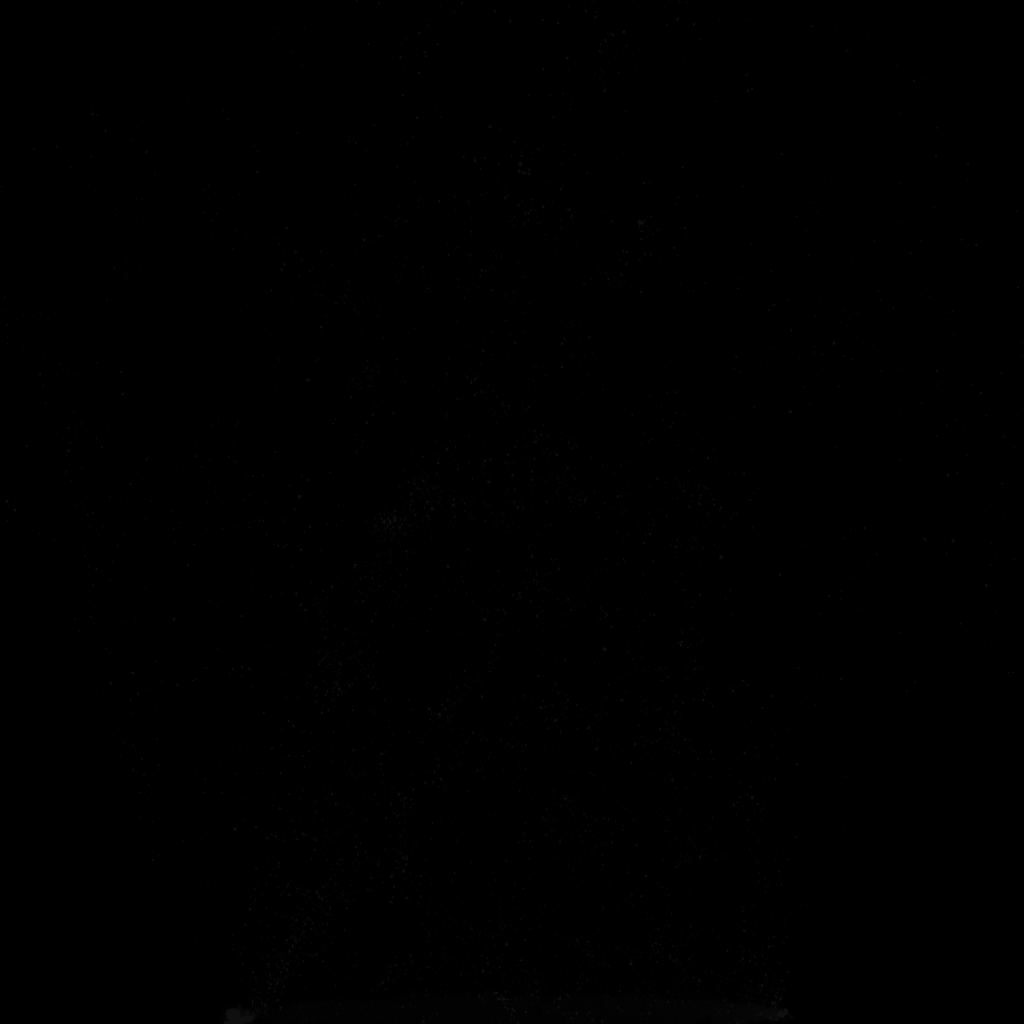

NameError: ignored

In [ ]:
cv2.destroyAllWindows()

color_red = (255, 0, 0)
color_green = (0, 255, 0)
color_red = (0, 0, 255)

# basepath = "/content/drive/MyDrive/Colab Notebooks/flame_front_analysis_images/Cam_Date=190923_Time=164708_Frame0/"
# basepath = "/content/drive/MyDrive/Colab Notebooks/flame_front_analysis_images/Window_Corrected_1403_1.png"

#%% Load image
# img_raw2 = cv2.imread(basepath)

images = ['B00001.tif']

contour_lengths_unconfined = []

# Unconfined
for image in images:
    # [contour, contour_length] =
    get_flame_contour_unconfined(image, color_red)
    # contour_lengths_unconfined.append(contour_length)


# # images = ['Window_Corrected_694_1.png', 'Window_Corrected_1529_1.png']
# # images = ['Window_Corrected_694_1.png']
# # # images = ['Window_Corrected_1529_1.png']

# # contour_lengths_confined = []

# # # Confined
# # for image in images:
# #     [contour, contour_length] = get_flame_contour_confined(image, color_red)
# #     contour_lengths_confined.append(contour_length)



# fig1, ax1 = plt.subplots()  

# x = contour[:,:,0]
# x = np.hstack(x)

# y = contour[:,:,1]
# y = np.hstack(y)*-1

# x_fit = np.linspace(min(x), max(x)) 

# start = 4
# end = 10
# poly_orders =  np.linspace(start, end, end - start + 1) 

# ax1.plot(x, y)

# for poly_order in poly_orders:
#     # Plot 4th order polynomial fit for laminar flame speed 
#     coeffs = np.polyfit(x, y, poly_order)
#     poly = np.poly1d(coeffs)
#     fit = poly(x_fit)
#     ax1.plot(x_fit, fit, ls="--", label=poly_order)

# ax1.legend()

## Flame front detection algoritm [confined]


In [ ]:
np.max(img_raw2)

255